# OOD with KNN

## Import Libraries

In [0]:
import os
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import faiss
from IPython import display
from lightning import LightningModule, Trainer, seed_everything
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.callbacks.progress import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.functional import accuracy

### Configuration

In [0]:
# use a fixed random seed
seed_everything(7, workers=True)

PATH_DATASETS = "datasets"
BATCH_SIZE = 64
NUM_WORKERS = int(os.cpu_count())

/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.9/site-packages/lightning/pytorch/utilities/seed.py:48: LightningDeprecationWarning: `lightning.pytorch.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning.lite.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
Global seed set to 7


### Load CIFAR-10 Dataset

In [0]:
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        # borrow from pl_bolts.transforms.dataset_normalizations.cifar10_normalization
        torchvision.transforms.Normalize(
            mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
            std=[x / 255.0 for x in [63.0, 62.1, 66.7]],
        ),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        # borrow from pl_bolts.transforms.dataset_normalizations.cifar10_normalization
        torchvision.transforms.Normalize(
            mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
            std=[x / 255.0 for x in [63.0, 62.1, 66.7]],
        ),
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root=PATH_DATASETS, train=True, download=True, transform=train_transforms
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
val_dataset = torchvision.datasets.CIFAR10(
    root=PATH_DATASETS, train=False, download=True, transform=test_transforms
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

Files already downloaded and verified
Files already downloaded and verified


### Resnet

Modify the pre-existing Resnet for CIFAR10 images (32x32)

In [0]:
def create_model():
    # do not use pre-trained model
    model = torchvision.models.resnet18(weights=None, num_classes=10)
    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    )
    model.maxpool = nn.Identity()
    return model

### Wrap Resnet with Pytorch Lightning

In [0]:
class LitResnet(LightningModule):
    def __init__(self, lr=0.05, num_classes=10):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def features(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=num_classes)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                total_steps=self.trainer.estimated_stepping_batches,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

### Train Resnet

In [0]:
model = LitResnet(lr=0.05, num_classes=10)

trainer = Trainer(
    max_epochs=30,
    accelerator="auto",
    devices="auto",
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[
        LearningRateMonitor(logging_interval="step"),
        TQDMProgressBar(refresh_rate=10),
    ],
    deterministic=True,
)

trainer.fit(model, train_loader, val_loader)
trainer.test(model, dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric ┃ DataLoader 0 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_acc │ 0.9404000043869019 │
│ test_loss │ 0.18965651094913483 │
└───────────────────────────┴───────────────────────────┘

Out[38]: [{'test_loss': 0.18965651094913483, 'test_acc': 0.9404000043869019}]

### Display Result

Out[39]: <seaborn.axisgrid.FacetGrid at 0x7f7032eff6a0>

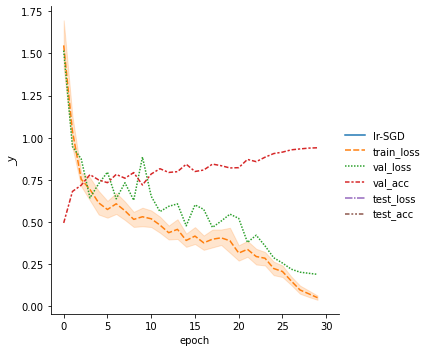

In [0]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
# display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

### Dump The Final Checkpoint

In [0]:
trainer.save_checkpoint("checkpoints/Resnet18-CIFAR10.ckpt")

## Process Out-of-Distribution Dataset

### Create SHVN DataLoader

In [0]:
image_size = 32
eval_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((image_size, image_size)),
        torchvision.transforms.CenterCrop(image_size),
        torchvision.transforms.ToTensor(),
        # borrow from pl_bolts.transforms.dataset_normalizations.cifar10_normalization
        torchvision.transforms.Normalize(
            mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
            std=[x / 255.0 for x in [63.0, 62.1, 66.7]],
        ),
    ]
)
ood_dataset = torchvision.datasets.SVHN(
    PATH_DATASETS, split="test", transform=eval_transforms, download=True
)
ood_loader = torch.utils.data.DataLoader(
    ood_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

  0%|          | 0/64275384 [00:00<?, ?it/s]

## Extract Features (Embedding)

### Reload Model

In [0]:
model = LitResnet.load_from_checkpoint(
    "checkpoints/Resnet18-CIFAR10.ckpt", map_location=torch.device("cpu")
)
model.eval()

Out[42]: LitResnet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
   

### Change CIFAR-10 Data Loader Transform Function

In [0]:
train_dataset = torchvision.datasets.CIFAR10(
    root=PATH_DATASETS,
    train=True,
    download=True,
    transform=test_transforms,
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)
val_dataset = torchvision.datasets.CIFAR10(
    root=PATH_DATASETS,
    train=False,
    download=True,
    transform=test_transforms,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

Files already downloaded and verified
Files already downloaded and verified


### Feature Extraction Function

In [0]:
def extract_features(model, dataloader):
    features = []
    for data, label in dataloader:
        # get the last hidden layer's output from model, size: (batch_size, 512, 4, 4)
        x = model.features(data)
        # avg pool, size: (batch_size, 512, 1, 1)
        x = F.adaptive_avg_pool2d(x, 1)
        # squeeze, size: (batch_size, 512)
        x = x.squeeze()
        # detach
        x = x.data.cpu().numpy()

        features.append(x)

    # merge as a large numpy array
    features = np.vstack(features)
    # ensure data type
    features = features.astype(np.float32)
    # normalization
    features = features / (
        np.linalg.norm(features, ord=2, axis=-1, keepdims=True) + 1e-10
    )

    return features

### CIFAR-10 Embedding

In [0]:
train_features = extract_features(model, train_loader)
test_features = extract_features(model, val_loader)

### OOD Embedding

In [0]:
ood_features = extract_features(model, ood_loader)

## KNN with FAISS

### Create Index with FAISS (CIFAR-10 Train)

In [0]:
index = faiss.IndexFlatL2(train_features.shape[1])
index.add(train_features)

### Find K-Nearest Points and Distances (CIFAR-10 Test)

In [0]:
k = 50
in_l2_distances, in_k_closest_points = index.search(test_features, k)

### Select the Furthest Distance Only (CIFAR-10 Test)

In [0]:
# in_l2_distances is sorted increasingly
in_scores = in_l2_distances[:, -1]

### Find K-Nearest Points and Distances (SHVN)

In [0]:
k = 50
out_l2_distances, out_k_closest_points = index.search(ood_features, k)

### Select the Furthest Distance Only (SHVN)

In [0]:
# out_l2_distances is sorted increasingly
out_scores = out_l2_distances[:, -1]

## Determine Threshold

### Sort In-of-Distribution and Out-of-Distribution Samples

In [0]:
in_scores.sort()
out_scores.sort()

### Find the Point Where TPR = 0.95

In [0]:
threshold = in_scores[round(0.95 * len(in_scores))]

## Calculate Metrics

Label 1 is in distribution  
Label 0 is out distribution

In [0]:
tp = 0
tn = 0
fp = 0
fn = 0

for point in in_scores:
    if point <= threshold:
        tp += 1
    else:
        fn += 1

for point in out_scores:
    if point <= threshold:
        fp += 1
    else:
        tn += 1

tp_rate = tp / (tp + fn)
tn_rate = tn / (tn + fp)
fp_rate = fp / (fp + tn)
fn_rate = fn / (fn + tp)

result = {
    "tp": tp,
    "tn": tn,
    "fp": fp,
    "fn": fn,
    "tpr": tp_rate,
    "fpr": fp_rate,
}

print(result)

{'tp': 9501, 'tn': 16281, 'fp': 9751, 'fn': 499, 'tpr': 0.9501, 'fpr': 0.3745774431468961}
